Mean Reversion Strategy on Brent and WTI Oil Prices

In [4]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#os.chdir('C:/Users/mattr/Documents/brent-wti-mean-reversion')
#print(os.getcwd())

__Loading Processed Data__

In [ ]:

from pathlib import Path

# Set BASE_DIR to the parent folder where "data" is located
BASE_DIR = Path.cwd()

# Now construct paths relative to BASE_DIR
spread_data_path = BASE_DIR / 'data' / 'processed' / 'spread_data.csv'

# Read the data
df = pd.read_csv(spread_data_path, parse_dates=['Date'])

print(df.head())


        Date  Brent    WTI      Spread
0 2005-06-23  57.03  59.23 -371.433395
1 2005-06-24  57.21  59.63 -405.835989
2 2005-06-27  58.50  59.78 -214.118434
3 2005-06-28  57.75  58.32  -97.736626
4 2005-06-29  55.42  57.23 -316.267692


__Explanatory Data Analysis__

Summary stats,
price plots,
spread behavior,
rolling mean/ std

Summary Statistics

In [5]:
print(df.info())
print(df.head())
print(df.describe())
print(df['Date'].head())
print(df['Date'].dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4925 entries, 0 to 4924
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4925 non-null   datetime64[ns]
 1   Brent   4925 non-null   float64       
 2   WTI     4925 non-null   float64       
 3   Spread  4925 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 154.0 KB
None
        Date  Brent    WTI      Spread
0 2005-06-23  57.03  59.23 -371.433395
1 2005-06-24  57.21  59.63 -405.835989
2 2005-06-27  58.50  59.78 -214.118434
3 2005-06-28  57.75  58.32  -97.736626
4 2005-06-29  55.42  57.23 -316.267692
                                Date        Brent          WTI        Spread
count                           4925  4925.000000  4925.000000   4925.000000
mean   2015-04-25 04:43:54.395939072    76.720619    72.300256    576.813486
min              2005-06-23 00:00:00     9.120000   -36.980000 -14694.429421
25%              2010-

Price Plots

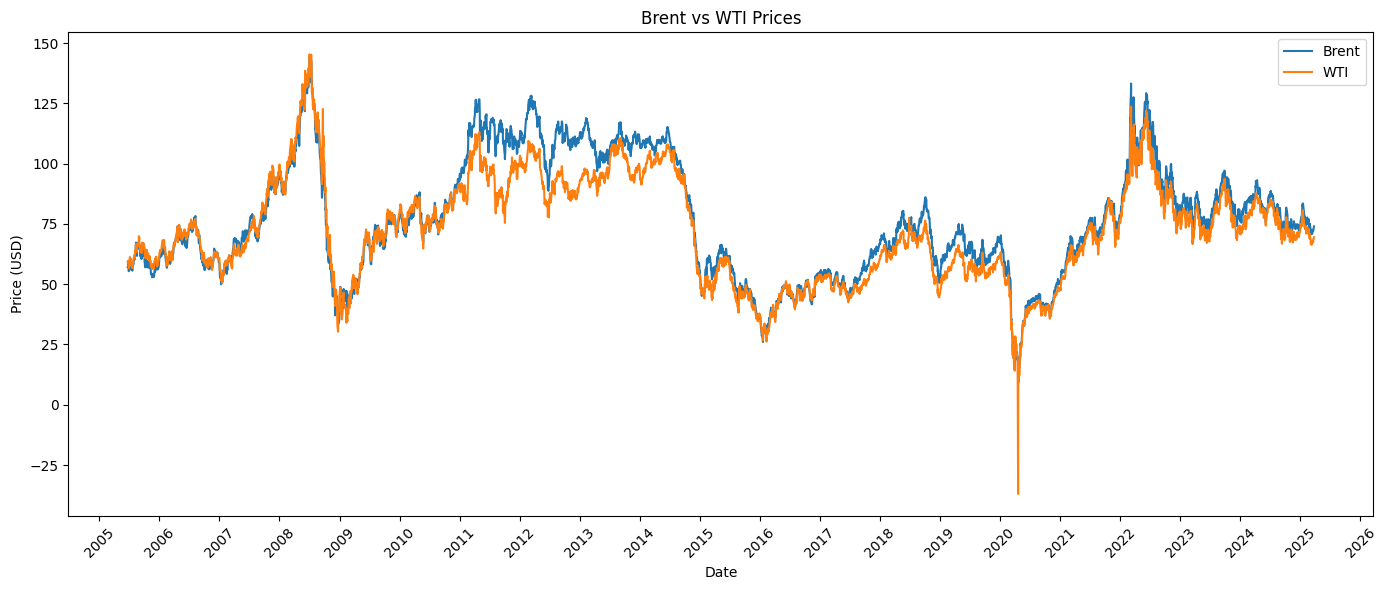

In [6]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df['Date'], df['Brent'], label='Brent')
ax.plot(df['Date'], df['WTI'], label='WTI')
ax.set_title('Brent vs WTI Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.legend()

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # One tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Spread Behavior

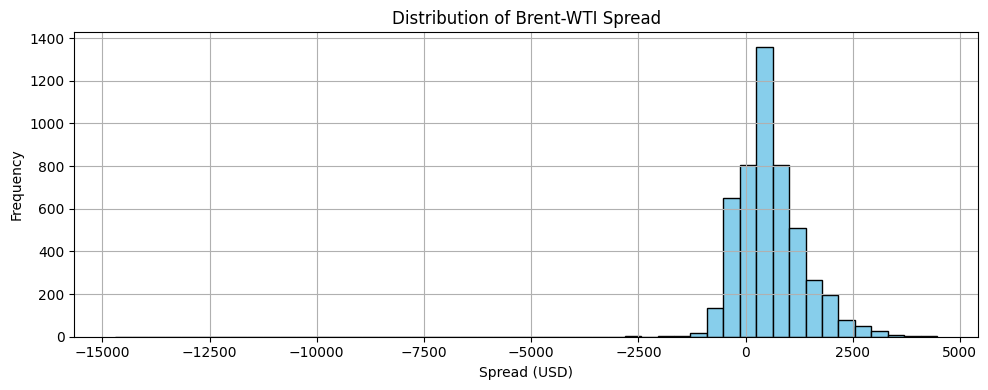

-14694.429421308816


In [5]:
plt.figure(figsize=(10, 4))
plt.hist(df['Spread'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Brent-WTI Spread')
plt.xlabel('Spread (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

print(min(df["Spread"]))


The histogram above shows the distribution of the Brent-WTI spread over 2005 to 2025. The spread is skewed to the right, with most values clustering between 0 and 10 USD, and a few large positive outliers. This supports the mean reversion hypothesis, as the spread tends to stay within a central range but occasionally deviates significantly, creating potential trading opportunities.

Rolling Mean and Standard Deviation of Spread

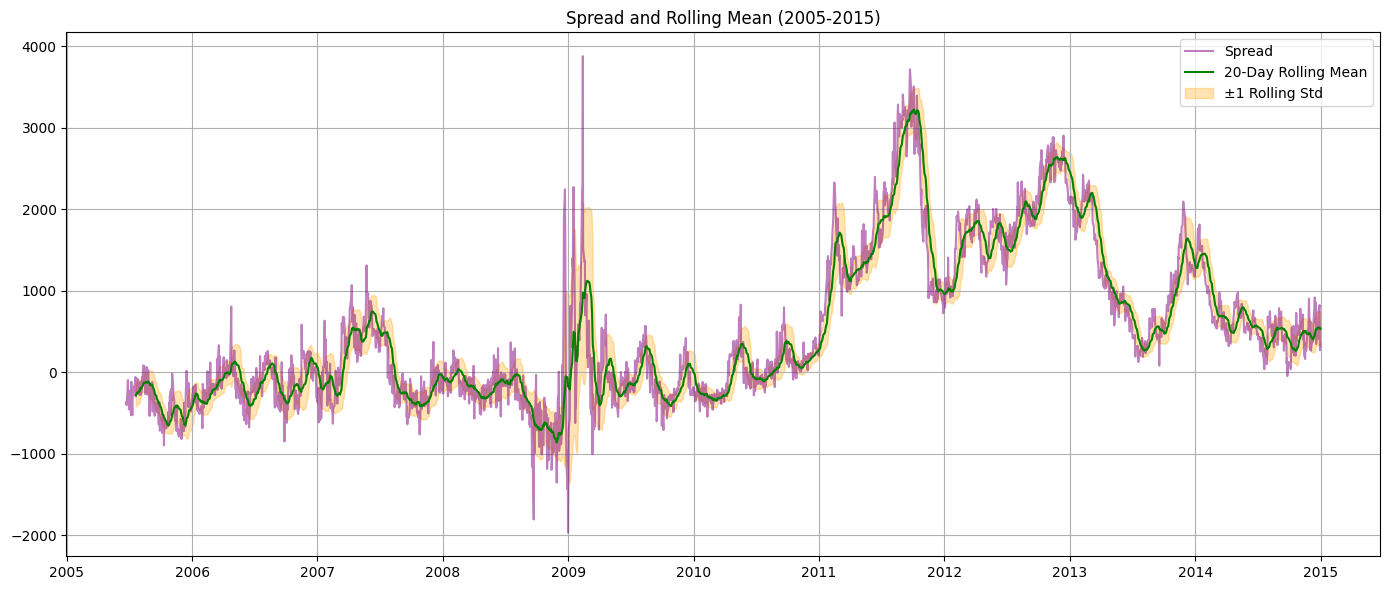

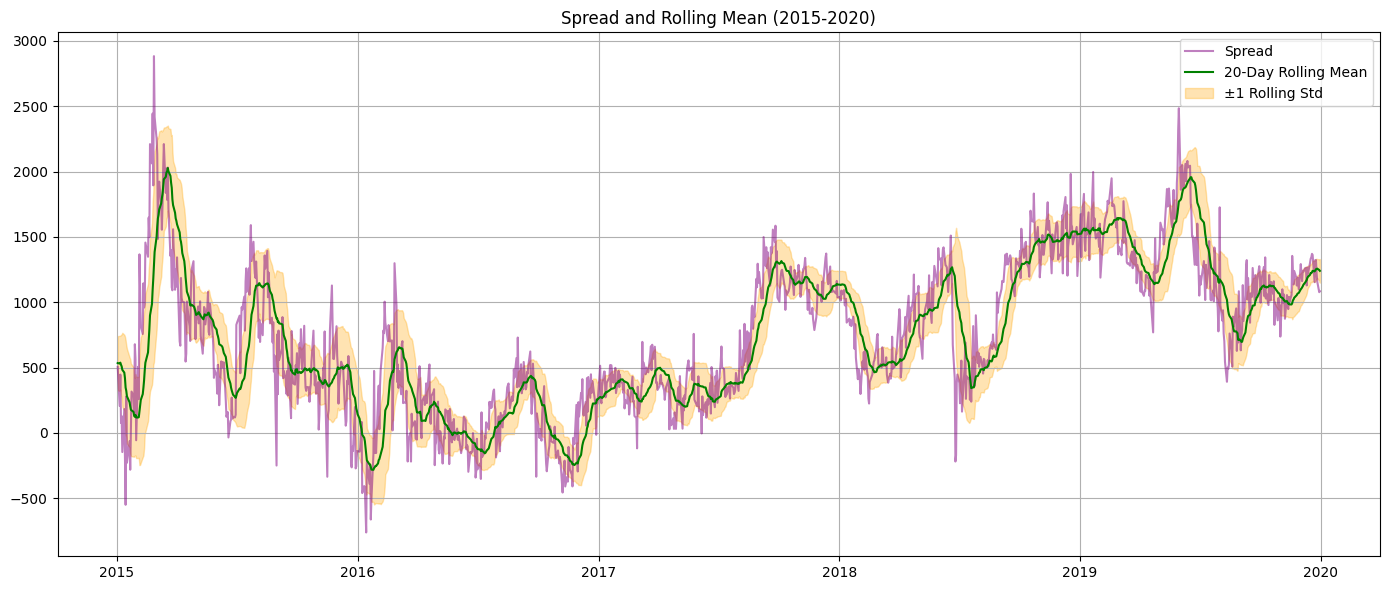

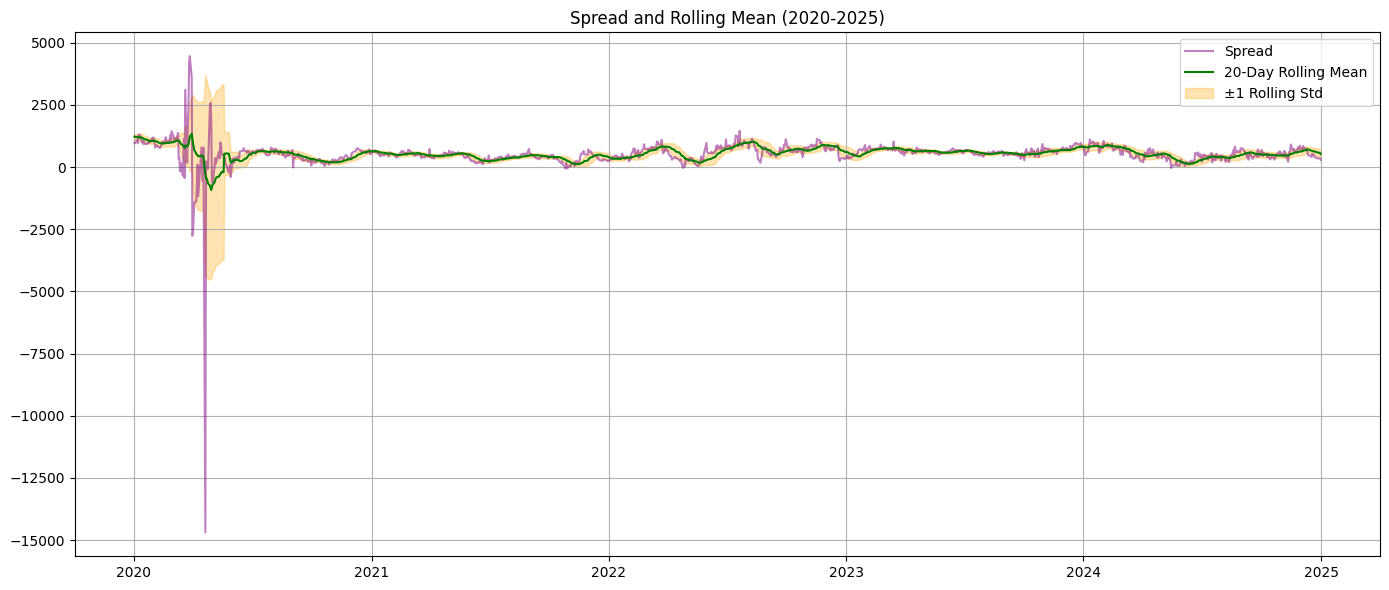

In [6]:
df['Spread_RollingMean'] = df['Spread'].rolling(window=20).mean()
df['Spread_RollingStd'] = df['Spread'].rolling(window=20).std()

years = ['2005-2015', '2015-2020', '2020-2025']

for year_range in years:
    start, end = year_range.split('-')
    df_window = df[(df['Date'] >= start) & (df['Date'] < end)]
    
    plt.figure(figsize=(14, 6))
    plt.plot(df_window['Date'], df_window['Spread'], label='Spread', color='purple', alpha=0.5)
    plt.plot(df_window['Date'], df_window['Spread_RollingMean'], label='20-Day Rolling Mean', color='green')
    plt.fill_between(df_window['Date'],
                     df_window['Spread_RollingMean'] + df_window['Spread_RollingStd'],
                     df_window['Spread_RollingMean'] - df_window['Spread_RollingStd'],
                     color='orange', alpha=0.3, label='±1 Rolling Std')
    plt.legend()
    plt.title(f'Spread and Rolling Mean ({year_range})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Correlation Check

In [7]:
correlation = df[['Brent', 'WTI']].corr()
print("Correlation between Brent and WTI Prices:")
print(correlation)

Correlation between Brent and WTI Prices:
          Brent       WTI
Brent  1.000000  0.969856
WTI    0.969856  1.000000


__Linear Regression and Fair Price__

Prepare Variables for Regression

In [8]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X = df['WTI']
y = df['Brent']

X = sm.add_constant(X)

#Fit the Ordinary Least Squares Regression Model
model = sm.OLS(y,X).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                  Brent   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 7.798e+04
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:55:02   Log-Likelihood:                -15691.
No. Observations:                4925   AIC:                         3.139e+04
Df Residuals:                    4923   BIC:                         3.140e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8239      0.293     -6.217      0.0

The Ordinary Linear Squares Regression shows a very strong linear relationship between WTI and Brent prices with an R-squared equal to 0.941. The model says that for every $1 increase in WTI, Brent increases by approximately $1.086. The model is statistically significant, but residual analysis indactes non-normality and positive autocorrelation. These residuals will serve as the basis for indentifying mean reversion opportunities.

In [9]:
df['Fair_Price'] = model.predict(X)

df['Residual'] = df['Brent'] - df['Fair_Price']

df_clean = df.dropna()

# Printing Rows to get a feel for the data
pd.set_option('display.max_rows', 100)
df_clean.head(10)

#df_clean.tail()
#df.to_csv('data/processed/spread_data_with_fair_price.csv', index=False)


,Date,Brent,WTI,Spread,Spread_RollingMean,Spread_RollingStd,Fair_Price,Residual
19,2005-07-21,55.59,57.31,-300.122143,-282.490411,140.918880,60.435713,-4.845713
20,2005-07-22,56.98,57.75,-133.333333,-270.585408,143.050760,60.913714,-3.933714
21,2005-07-25,57.51,58.16,-111.760660,-255.881641,143.529833,61.359125,-3.849125
22,2005-07-26,58.58,59.05,-79.593565,-249.155398,148.650760,62.325990,-3.745990
23,2005-07-27,58.34,59.12,-131.935047,-250.865319,147.004907,62.402036,-4.062036
24,2005-07-28,58.28,59.91,-272.074779,-248.655673,146.300543,63.260265,-4.980265
25,2005-07-29,59.77,60.71,-154.834459,-245.184258,147.726547,64.129358,-4.359358
26,2005-08-01,60.56,61.51,-154.446431,-230.067805,140.212597,64.998451,-4.438451
27,2005-08-02,60.13,61.87,-281.234847,-228.638005,139.500408,65.389543,-5.259543
28,2005-08-03,60.04,60.76,-118.499013,-211.212204,129.570289,64.183676,-4.143676


Fair Price vs Actaul Brent Price Weekly Plotted

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(df_resampled.index, df_resampled['Brent'], label='Actual Brent')
plt.plot(df_resampled.index, df_resampled['Fair_Price'], label='Fair Price')
plt.legend()
plt.title('Brent Price vs Fair Price (Weekly Average)')
plt.grid(True)
plt.show()



NameError: name 'df_resampled' is not defined

<Figure size 1400x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(df_clean['Residual'], bins=50, color='red', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


print('Residual Mean:', df_clean['Residual'].mean())
print("Residual Median: ", df_clean['Residual'].median())
print('Residual Std Dev:', df_clean['Residual'].std())
print('Residual Skewness:', df_clean['Residual'].skew())


NameError: name 'plt' is not defined

__Feature Engineering and Signal Labeling__

Prepare new features and labels for KNN Classifier to predict mean reversion trading signals

Create statistical features that will help your KNN model predict mean reversion signals.

Label your data points as Signal = 1 (mean reversion opportunity) or Signal = 0 (no opportunity) based on how extreme the mispricing is.

Prepare a clean dataset to feed into your machine learning model.

In [ ]:
df = pd.read_csv('data/processed/spread_data_with_fair_price.csv', parse_dates=['Date'])

# Need to calculate residual z-score which tells todays mispricing is extreme based compared to recent behavior

# Rollinig window size
window_size = 20

#Calculate Rolling mean of Residual
df_clean["Residual_Mean"] = df_clean['Residual'].rolling(window=window_size).mean()

#Calculate Rolling STD of Residual
df_clean['Residual_Std'] = df_clean['Residual'].rolling(window=window_size).std()

df_clean.head(10000)





,Date,Brent,WTI,Spread,Spread_RollingMean,Spread_RollingStd,Fair_Price,Residual,Residual_Mean,Residual_Std,Signal,Profit_Signal_3,Profit_Signal_5,Profit_Signal_10,Residual_Z,Residual_Magnitude,Signal_Strength,Trade_Direction,Price_Ratio
38,2005-08-17,63.41,63.29,0.12,-0.7715,0.703721,66.932183,-3.522183,NaN,NaN,0,0,0,0,1.252050,3.522183,5.652208,1,1.001896
39,2005-08-18,61.75,63.47,-1.72,-0.7715,0.703721,67.127729,-5.377729,NaN,NaN,0,1,0,0,-1.593936,5.377729,8.173478,1,0.972901
40,2005-08-19,64.21,65.51,-1.30,-0.7980,0.713572,69.343915,-5.133915,NaN,NaN,1,0,1,0,-1.104343,5.133915,7.611179,1,0.980156
41,2005-08-22,65.87,65.46,0.41,-0.7450,0.762810,69.289597,-3.419597,NaN,NaN,0,0,0,0,1.356112,3.419597,4.892052,1,1.006263
42,2005-08-23,65.16,65.81,-0.65,-0.7540,0.760453,69.669825,-4.509825,NaN,NaN,0,1,0,0,-0.152199,4.509825,6.593609,1,0.990123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,2025-03-18,71.93,67.49,4.44,4.3575,0.404135,71.494920,0.435080,0.250236,0.516632,0,0,0,0,0.357786,0.435080,0.842146,-1,1.065788
4921,2025-03-19,71.94,67.40,4.54,4.3965,0.380378,71.397147,0.542853,0.311605,0.470598,0,0,0,0,0.491392,0.542853,1.153538,-1,1.067359
4922,2025-03-20,72.61,68.55,4.06,4.3960,0.380836,72.646468,-0.036468,0.329803,0.448114,0,0,0,0,-0.817362,0.036468,0.081382,1,1.059227
4923,2025-03-21,72.64,68.52,4.12,4.3940,0.382243,72.613877,0.026123,0.337303,0.441325,0,0,0,0,-0.705105,0.026123,0.059191,-1,1.060128


__Train and Evaluate KNN Model__

Target Variable

In [ ]:
# Signal #1
# Yes(1) -> mean reversion expected
# No(0) -> no reversion expected
N = 10
df_clean['Signal'] = (df_clean['Residual'].shift(-N).abs() < df_clean['Residual'].abs()).astype(int)
df_clean.head(5)

,Date,Brent,WTI,Spread,Spread_RollingMean,Spread_RollingStd,Fair_Price,Residual,Residual_Mean,Residual_Std,Signal,Profit_Signal_3,Profit_Signal_5,Profit_Signal_10,Residual_Z,Residual_Magnitude,Signal_Strength,Trade_Direction,Price_Ratio
38,2005-08-17,63.41,63.29,0.12,-0.7715,0.703721,66.932183,-3.522183,NaN,NaN,0,0,0,0,1.252050,3.522183,5.652208,1,1.001896
39,2005-08-18,61.75,63.47,-1.72,-0.7715,0.703721,67.127729,-5.377729,NaN,NaN,0,1,0,0,-1.593936,5.377729,8.173478,1,0.972901
40,2005-08-19,64.21,65.51,-1.30,-0.7980,0.713572,69.343915,-5.133915,NaN,NaN,1,0,1,0,-1.104343,5.133915,7.611179,1,0.980156
41,2005-08-22,65.87,65.46,0.41,-0.7450,0.762810,69.289597,-3.419597,NaN,NaN,0,0,0,0,1.356112,3.419597,4.892052,1,1.006263
42,2005-08-23,65.16,65.81,-0.65,-0.7540,0.760453,69.669825,-4.509825,NaN,NaN,0,1,0,0,-0.152199,4.509825,6.593609,1,0.990123


Feature Matrix(X) and Target Vector(Y)

In [ ]:
features = [
    'Spread',
    'Spread_RollingMean',
    'Spread_RollingStd',
    'Residual',
    'Residual_Mean',
    'Residual_Std',
]

df_clean = df_clean.dropna(subset=features + ['Signal'])


X = df_clean[features]
y = df_clean['Signal']

Train KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate (tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_year_start = df_clean.iloc[train_index[0]]['Date'].year
    train_year_end = df_clean.iloc[train_index[0]]['Date'].year
    test_year_start = df_clean.iloc[test_index[0]]['Date'].year
    test_year_end = df_clean.iloc[test_index[-1]]['Date'].year


    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    print(f"Fold {fold + 1} Results: (Train: {train_year_start}-{train_year_end} | Test: {test_year_start}-{test_year_end}")
    print(classification_report(y_test, y_pred))
    

Fold 1 Results: (Train: 2005-2005 | Test: 2008-2012
              precision    recall  f1-score   support

           0       0.54      0.46      0.49       399
           1       0.54      0.62      0.58       412

    accuracy                           0.54       811
   macro avg       0.54      0.54      0.53       811
weighted avg       0.54      0.54      0.53       811

Fold 2 Results: (Train: 2005-2005 | Test: 2012-2015
              precision    recall  f1-score   support

           0       0.51      0.86      0.64       394
           1       0.62      0.21      0.32       417

    accuracy                           0.53       811
   macro avg       0.56      0.54      0.48       811
weighted avg       0.56      0.53      0.47       811

Fold 3 Results: (Train: 2005-2005 | Test: 2015-2018
              precision    recall  f1-score   support

           0       0.57      0.84      0.68       414
           1       0.67      0.35      0.46       397

    accuracy              

Train XGBoost

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.05,
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    use_label_encoder = False,
    eval_metric = 'logloss'
)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(f"Predicted 1s: {y_pred.sum()} / {len(y_pred)}")
print(f"Fold {fold + 1} Results")
print(classification_report(y_test, y_pred))

Predicted 1s: 177 / 814
Fold 5 Results
              precision    recall  f1-score   support

           0       0.59      0.89      0.71       424
           1       0.75      0.34      0.47       390

    accuracy                           0.63       814
   macro avg       0.67      0.62      0.59       814
weighted avg       0.67      0.63      0.60       814



c:\Users\mattr\Documents\brent-wti-mean-reversion\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:20:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The XGBoost model predicted whether the residual which is the difference between the actaul price of WTI and its fair price. That it would shrink within the next 10 days, showing a mean reversion oppurtinity. The fair price is an estimated value for WTI based on its historical relationship with Brent crude. It reflects where WTI 'should' be priced if its correlation with Brent holds. When the model identifies that WTI is significantly overpriced or underpriced relative to this fair value, the residual becomes large and either positive or negative. In this fold the model predicted 177 out of 814 cases as likely to revert toward fair value (Signal = 1) and it was correct 75% of f the time that it made prediction (precision). But, it only captured 34% of all actaul reversion events (recall) meaning it was selective and missed many opportunities. Overall accuracy was 63%, with especially strong performance in identifying when mean reversion was unlikely. This suggests the model is conservative but effective at spotting high-confidence mispricings where the WTI-Brent relationship may correct.

__New Revised Strategy__

Predicting: Whether a long or short residual-based trade will produce a profitable return over the next N days.

Simpler Terms: If i enter a trade today based on the residual, will i make money within N days?

How the strategy will work:

Looks at the residual today.

    -if its positive -> short WTI, long Brent

    -if its negative -> long WTI, short Brent

Looks at N days ahead and checks:

    -Did the spread between WTI and Brent move in my favor?
    
    -Did it move enough (e.g. atleast $0.50) to be a good trade?

Profit-Based Labels (Per N)

if residual > 0 short Brent, Long WTI

if residual < 0 long Brent, short WTI

In [ ]:
# Holding periods
N_values = [3,5,10]
# Minimum profit in spread movement for it to be profitable
profitable_threshold = 0.5

def generate_profit_labels(df_clean, N, threshold):

    """
    Create binary profit labels based on residual-driven trades over N-day horizons.

    Parameters:
    - df: your DataFrame with Residual and Spread
    - N: number of days to simulate holding the trade
    - threshold: profit threshold in spread movement (e.g. 0.50)

    Returns:
    - A binary Series: 1 if trade would have been profitable, else 0
    """
    # determine trade direction: +1 for long (residual < 0), -1 for short (residual) > 0
    
    direction = np.where(df_clean['Residual'] < 0, 1, -1) # 1 -> Long, -1, -> Short
    # Calculate sperad over n days in profitable direction
    spread_move = (df_clean['Spread'].shift(-N)- df_clean['Spread']) * direction

    #Label as 1 if the spread moved enough in profitable direction
    return (spread_move >= threshold).astype(int)

for N in N_values:
    #Create a new column like Profit_Signal_3, etc
    df_clean[f"Profit_Signal_{N}"] = generate_profit_labels(df_clean, N, profitable_threshold)

df_clean.head(3) 


,Date,Brent,WTI,Spread,Spread_RollingMean,Spread_RollingStd,Fair_Price,Residual,Residual_Mean,Residual_Std,Signal,Profit_Signal_3,Profit_Signal_5,Profit_Signal_10
38,2005-08-17,63.41,63.29,0.12,-0.7715,0.703721,66.932183,-3.522183,-4.302400,0.623152,0,0,0,0
39,2005-08-18,61.75,63.47,-1.72,-0.7715,0.703721,67.127729,-5.377729,-4.329001,0.657949,0,1,0,0
40,2005-08-19,64.21,65.51,-1.30,-0.7980,0.713572,69.343915,-5.133915,-4.389011,0.674523,1,0,1,0


Add Z-Score,of Residual, Residual Magnitude, Signal Strength, trade direction, brent/price ratio  to Column

Z-score -> standardized residual that tells you how extreme today's residual is compared to its recent behavior.

It will normalize a residual of 2 which might be huge in a queit market, but normal in a volatile one. 


In [ ]:
# Z-score of residual
df_clean['Residual_Z'] = (df_clean['Residual'] - df_clean['Residual_Mean']) / df_clean['Residual_Std']

# Residual magnitude
df_clean['Residual_Magnitude'] = df_clean['Residual'].abs()

# Signal strength (normalized mispricing)
df_clean['Signal_Strength'] = df_clean['Residual_Magnitude'] / df_clean['Residual_Std']

# Trade direction: +1 for long, -1 for short
df_clean['Trade_Direction'] = np.where(df_clean['Residual'] < 0, 1, -1)

# Brent / WTI price ratio
df_clean['Price_Ratio'] = df_clean['Brent'] / df_clean['WTI'] 

df_clean.head(10)



,Date,Brent,WTI,Spread,Spread_RollingMean,Spread_RollingStd,Fair_Price,Residual,Residual_Mean,Residual_Std,Signal,Profit_Signal_3,Profit_Signal_5,Profit_Signal_10,Residual_Z,Residual_Magnitude,Signal_Strength,Trade_Direction,Price_Ratio
38,2005-08-17,63.41,63.29,0.12,-0.7715,0.703721,66.932183,-3.522183,-4.302400,0.623152,0,0,0,0,1.252050,3.522183,5.652208,1,1.001896
39,2005-08-18,61.75,63.47,-1.72,-0.7715,0.703721,67.127729,-5.377729,-4.329001,0.657949,0,1,0,0,-1.593936,5.377729,8.173478,1,0.972901
40,2005-08-19,64.21,65.51,-1.30,-0.7980,0.713572,69.343915,-5.133915,-4.389011,0.674523,1,0,1,0,-1.104343,5.133915,7.611179,1,0.980156
41,2005-08-22,65.87,65.46,0.41,-0.7450,0.762810,69.289597,-3.419597,-4.367534,0.699011,0,0,0,0,1.356112,3.419597,4.892052,1,1.006263
42,2005-08-23,65.16,65.81,-0.65,-0.7540,0.760453,69.669825,-4.509825,-4.405726,0.683969,0,1,0,0,-0.152199,4.509825,6.593609,1,0.990123
43,2005-08-24,65.25,67.10,-1.85,-0.8075,0.799038,71.071238,-5.821238,-4.493686,0.747602,0,0,0,0,-1.775746,5.821238,7.786544,1,0.972429
44,2005-08-25,65.88,67.29,-1.41,-0.7965,0.788565,71.277647,-5.397647,-4.514555,0.767462,1,0,0,0,-1.150666,5.397647,7.033117,1,0.979046
45,2005-08-26,66.23,66.05,0.18,-0.7405,0.817090,69.930553,-3.700553,-4.481615,0.788328,0,0,0,0,0.990783,3.700553,4.694179,1,1.002725
46,2005-08-29,64.77,67.41,-2.64,-0.8250,0.920712,71.408011,-6.638011,-4.591593,0.923781,1,0,1,1,-2.215264,6.638011,7.185701,1,0.960837
47,2005-08-30,66.15,69.91,-3.76,-0.9260,1.116373,74.123926,-7.973926,-4.727312,1.188534,1,1,1,0,-2.731611,7.973926,6.709041,1,0.946217


Clean and Normalize Features

In [ ]:
df_clean.to_csv('df_clean.csv', index = False)